In [1]:
!pip install xgboost
import xgboost
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

/home/krishna/research/machine-learning/random-forest-liquefaction/env/lib64/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = 'RF_YN_Model3.csv'
df = pd.read_csv(data)
df.head()

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Displ (m),Target
0,0.370809,0.909116,0.319117,5.465739,0.546270,0.000000,0
1,1.300896,1.123009,0.211770,0.905948,0.532398,0.195432,0
2,1.300896,0.847858,0.195947,0.849104,0.532398,0.217259,0
3,1.788212,2.044325,0.115795,0.451034,0.542307,0.239763,0
4,1.637517,2.003797,0.137265,0.941866,0.545784,0.377358,1


In [3]:
#define features matrix (X) and target (y)
X = df.drop(['Displ (m)', 'Target'], axis = 1)
y = df.drop(['GWD (m)', 'Elevation',  'L (km)', 'Slope (%)','PGA (g)','Displ (m)'],axis=1)

# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_display,y_display = shap.datasets.adult(display=True)

In [4]:
# Regression fit
model = xgboost.XGBClassifier().fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[09:43:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
# make prediction
preds = model.predict(X_test)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.72%


In [6]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


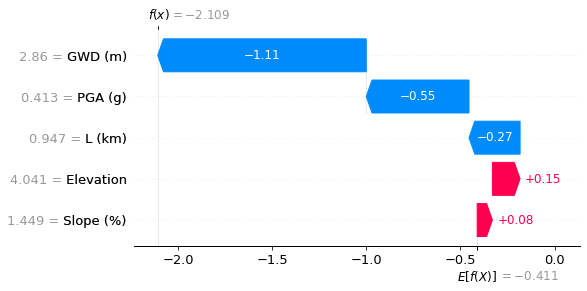

In [7]:
# visualize no lateral spreading prediction explanation
shap.plots.waterfall(shap_values[0])

In [8]:
# visualize the no lateral spreading prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

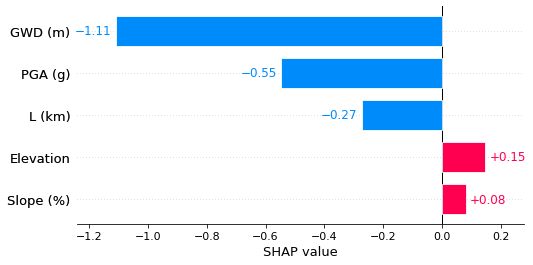

In [23]:
shap.plots.bar(shap_values[0])

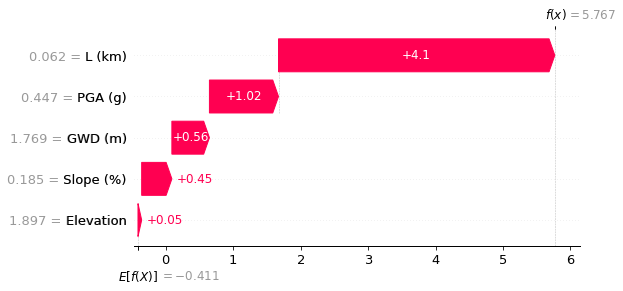

In [9]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(shap_values[2])

In [10]:
# visualize lateral spreading explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[2])

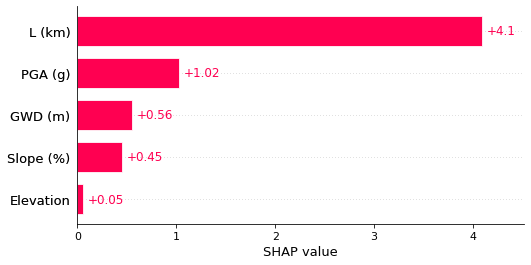

In [24]:
shap.plots.bar(shap_values[2])

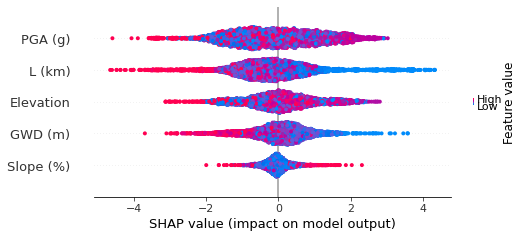

In [11]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

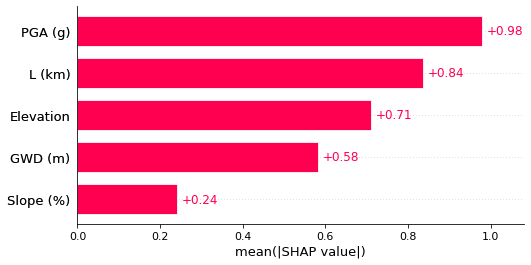

In [12]:
shap.plots.bar(shap_values)

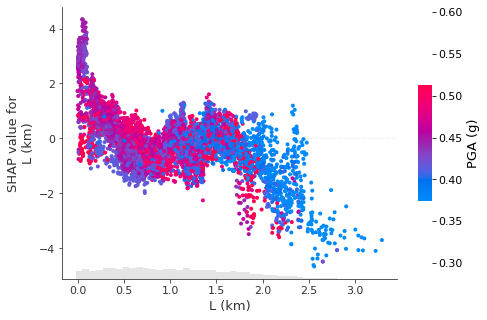

In [13]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"L (km)"], color=shap_values)

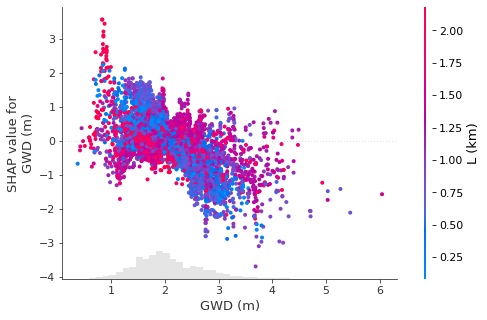

In [14]:
shap.plots.scatter(shap_values[:,"GWD (m)"], color=shap_values)

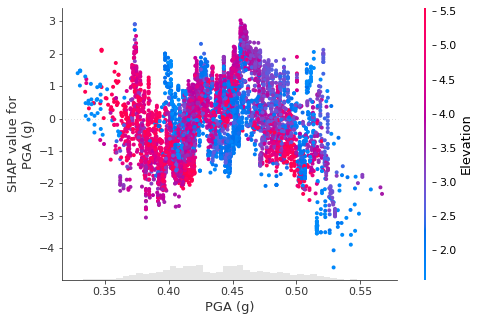

In [15]:
shap.plots.scatter(shap_values[:,"PGA (g)"], color=shap_values)

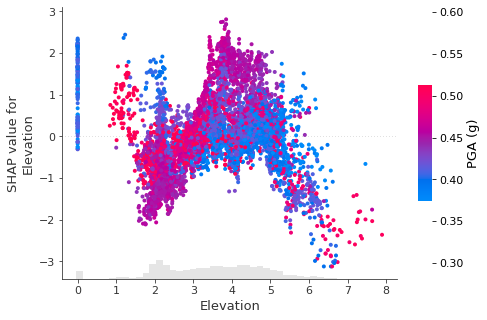

In [16]:
shap.plots.scatter(shap_values[:,"Elevation"], color=shap_values)

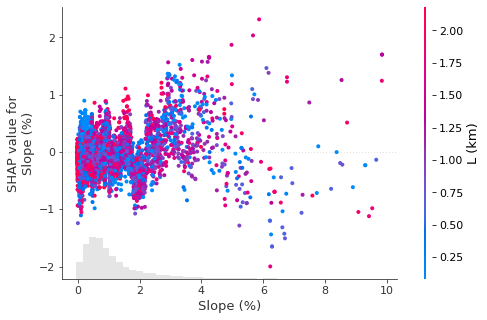

In [17]:
shap.plots.scatter(shap_values[:,"Slope (%)"], color=shap_values)